# NASA Space Apps Challenge 2025

## 0.Libraries

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import precision_recall_curve
import json

## 1. Loading Dataset

In [116]:
# set data directory
DATA_DIR = Path("./data")
KOI_FILE = DATA_DIR / "Kepler Objects of Interest (KOI).csv"
TOI_FILE = DATA_DIR / "TESS Objects of Interest (TOI).csv"
K2_FILE = DATA_DIR / "K2 Planets and Candidates.csv"


In [117]:
# Kepler Objects of Interest (KOI)
koi = pd.read_csv(
    KOI_FILE,
    skiprows=range(53),   
    header=0,
    encoding="utf-8-sig",
    low_memory=False
)

koi.head()


,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


## 2. Data Preprocessing

In [120]:
# Copy the dataset
koi_df = koi.copy()

In [121]:
def preprocess_koi_df(koi_df):
    # Remove columns
    columns_to_remove = ['kepid', 'kepoi_name', 'kepler_name', 'koi_pdisposition', 'koi_score', 'koi_teq_err1', 'koi_teq_err2']

    # Remove columns
    for c in columns_to_remove:
        if c in koi_df.columns:
            koi_df.drop(columns=c, inplace=True)
    
    # Only keep Candidate / Confirmed
    koi_df = koi_df[koi_df['koi_disposition'].isin(['CANDIDATE', 'CONFIRMED'])]

    # Binary label: Candidate=1, Confirmed=0
    koi_df['y'] = (koi_df['koi_disposition'] == 'CANDIDATE').astype(int)

    # Fill missing values
    for col in koi_df.columns:
        if koi_df[col].dtype in [np.float64, np.int64]:
            koi_df[col].fillna(koi_df[col].mean(), inplace=True)
        else:
            # Fill missing values with mode
            mode = koi_df[col].mode()
            if not mode.empty:
                koi_df[col].fillna(mode[0], inplace=True)
            else:
                koi_df[col].fillna("missing", inplace=True)

    # Separate features and labels
    X = koi_df.drop(['koi_disposition', 'y'], axis=1, errors='ignore')
    y = koi_df['y']

    # Ensure all features are numeric
    X = X.select_dtypes(include=[np.number])

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    # First split into training and temp sets (train:temp = 70%:30%)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )
    # Then split the temp set into validation and test sets 
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    return X_train, X_val, X_test, y_train, y_val, y_test, X_scaled.columns.tolist(),scaler

# Preprocess the dataset
X_train_koi, X_val_koi, X_test_koi, y_train_koi, y_val_koi, y_test_koi, X_scaled_koi_columns, scaler_koi = preprocess_koi_df(koi_df)
print("All feature columns:", X_scaled_koi_columns)
print(f"Train set: {X_train_koi.shape}, Validation set: {X_val_koi.shape}, Test set: {X_test_koi.shape}")
print(f"Train labels: {y_train_koi.shape}, Validation labels: {y_val_koi.shape}, Test labels: {y_test_koi.shape}")



All feature columns: ['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag']
Train set: (3307, 40), Validation set: (709, 40), Test set: (709, 40)
Train labels: (3307,), Validation labels: (709,), Test labels: (709,)


## 3. Model

### 3.1 LGBM

#### Base Model Implement

In [122]:
def train_lgbm_base(X_train, y_train, X_val, y_val):
    model = lgb.LGBMClassifier()
    model.fit(X_train, y_train)

    # predict
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    print(f"\nTrain Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return model, y_train_pred, y_val_pred, train_accuracy, val_accuracy

# train result
train_lgbm_base(X_train_koi, y_train_koi, X_val_koi, y_val_koi)


Train Accuracy: 0.9988, Validation Accuracy: 0.8759


(LGBMClassifier(),
 array([0, 0, 0, ..., 0, 1, 1]),
 array([0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1

#### Hyper-parameters Tuning

In [123]:
def train_LGBM(X_train, y_train, n_trials=40):
    # define objective function
    def objective(trial):
        params = {
            "objective": "binary",
            "metric": "auc",
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 31, 255),
            "max_depth": trial.suggest_int("max_depth", -1, 12),
            "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
            "random_state": 42,
            "verbosity": -1,
            "n_estimators": 5000,
        }

        X = np.array(X_train)
        y = np.array(y_train)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        pr_scores = []
        for tr_idx, va_idx in skf.split(X, y):
            Xtr, Xva = X[tr_idx], X[va_idx]
            ytr, yva = y[tr_idx], y[va_idx]
            model = lgb.LGBMClassifier(**params)
            model.fit(
                Xtr, ytr,
                eval_set=[(Xva, yva)],
                eval_metric="auc",
                callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
            )
            proba = model.predict_proba(Xva)[:, 1]
            pr_scores.append(average_precision_score(yva, proba))
        return np.mean(pr_scores)

    # create Optuna optimizer
    study = optuna.create_study(direction="maximize", study_name="lgbm_pr_auc")
    study.optimize(lambda t: objective(t), n_trials=n_trials, show_progress_bar=True)

    # get best parameters
    best_params = study.best_trial.params

    # train best model
    best_model = lgb.LGBMClassifier(**best_params)
    best_model.fit(
        X_train, y_train,
        eval_metric="aucpr"
    )

    # output results
    print("Best LGBM params:", best_params)
    print("Best CV PR-AUC:", study.best_value)

    return best_model, best_params


In [124]:
print("Train LGBM model")
best_lgbm_model, best_lgbm_params = train_LGBM(X_train_koi, y_train_koi, n_trials=40)

[I 2025-10-05 14:59:43,509] A new study created in memory with name: lgbm_pr_auc


Train LGBM model


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-10-05 14:59:45,014] Trial 0 finished with value: 0.9255716195634708 and parameters: {'learning_rate': 0.026822456870844447, 'num_leaves': 150, 'max_depth': 2, 'min_child_samples': 51, 'subsample': 0.6161811438970609, 'colsample_bytree': 0.8831636553850064, 'reg_lambda': 0.25176630231549, 'reg_alpha': 0.07285461471510507}. Best is trial 0 with value: 0.9255716195634708.
[I 2025-10-05 14:59:46,042] Trial 1 finished with value: 0.9235831118844988 and parameters: {'learning_rate': 0.06240840285408514, 'num_leaves': 178, 'max_depth': 7, 'min_child_samples': 60, 'subsample': 0.851823160031213, 'colsample_bytree': 0.7094729016906847, 'reg_lambda': 0.003490099675785345, 'reg_alpha': 5.1432345824839345}. Best is trial 0 with value: 0.9255716195634708.
[I 2025-10-05 14:59:48,142] Trial 2 finished with value: 0.928078677703256 and parameters: {'learning_rate': 0.026572778953744526, 'num_leaves': 249, 'max_depth': -1, 'min_child_samples': 88, 'subsample': 0.6778401673830601, 'colsample_byt

### 3.2 CatBoost

#### Base Model Implement

In [125]:
def train_catboost_base(X_train, y_train, X_val, y_val):
    # initialize model
    model = CatBoostClassifier()
    # train model
    model.fit(
        Pool(X_train, y_train),
        eval_set=Pool(X_val, y_val),
        early_stopping_rounds=300,
        use_best_model=True,
        verbose=False
    )

    # predict
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    print(f"\nTrain Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return model, y_train_pred, y_val_pred, train_accuracy, val_accuracy

# train result
train_catboost_base(X_train_koi, y_train_koi, X_val_koi, y_val_koi)



Train Accuracy: 0.9631, Validation Accuracy: 0.8815


(<catboost.core.CatBoostClassifier at 0x21e75627aa0>,
 array([0, 0, 0, ..., 1, 1, 1], dtype=int64),
 array([0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 0

#### Hyper-parameters Tuning

In [128]:
def train_CatBoost(X_train, y_train, n_trials=40):
    # define Optuna objective function
    def objective(trial):
        params = {
            "iterations": trial.suggest_int("iterations", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "depth": trial.suggest_int("depth", 4, 10),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
            "random_strength": trial.suggest_float("random_strength", 1e-3, 10, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "verbose": False,
            "task_type": "CPU"
        }
        X = np.array(X_train)
        y = np.array(y_train)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        pr_scores = []
        for tr_idx, va_idx in skf.split(X, y):
            Xtr, Xva = X[tr_idx], X[va_idx]
            ytr, yva = y[tr_idx], y[va_idx]
            model = CatBoostClassifier(**params)
            model.fit(
                Pool(Xtr, ytr),
                eval_set=Pool(Xva, yva),
                early_stopping_rounds=200,
                use_best_model=True,
                verbose=False
            )
            proba = model.predict_proba(Xva)[:, 1]
            pr_scores.append(average_precision_score(yva, proba))
        return np.mean(pr_scores)

    # create Optuna optimizer
    study = optuna.create_study(direction="maximize", study_name="catboost_pr_auc")
    study.optimize(lambda t: objective(t), n_trials=n_trials, show_progress_bar=True)

    # get best parameters
    best_params = study.best_trial.params

    # train best model
    best_model = CatBoostClassifier(**best_params)
    best_model.fit(
        Pool(X_train, y_train),
        verbose=False
    )

    # output results
    print("Best CatBoost params:", best_params)
    print("Best CV PR-AUC:", study.best_value)

    return best_model, best_params

In [129]:
print("Train CatBoost model")
best_catboost_model, best_catboost_params = train_CatBoost(X_train_koi, y_train_koi, n_trials=40)

[I 2025-10-05 15:09:59,393] A new study created in memory with name: catboost_pr_auc


Train CatBoost model


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-10-05 15:10:07,974] Trial 0 finished with value: 0.9241000728853693 and parameters: {'iterations': 338, 'learning_rate': 0.0885388311063663, 'depth': 9, 'l2_leaf_reg': 3.5579636064925326, 'random_strength': 0.014451684810973973, 'bagging_temperature': 0.3648974108613713, 'border_count': 68}. Best is trial 0 with value: 0.9241000728853693.
[I 2025-10-05 15:10:50,992] Trial 1 finished with value: 0.926741700868573 and parameters: {'iterations': 750, 'learning_rate': 0.006210811958201743, 'depth': 9, 'l2_leaf_reg': 3.10893668188427, 'random_strength': 0.22663599775072268, 'bagging_temperature': 0.1908569282271516, 'border_count': 190}. Best is trial 1 with value: 0.926741700868573.
[I 2025-10-05 15:10:53,930] Trial 2 finished with value: 0.9263794618119962 and parameters: {'iterations': 107, 'learning_rate': 0.041414633469601704, 'depth': 7, 'l2_leaf_reg': 7.071567658392469, 'random_strength': 2.6013112032083616, 'bagging_temperature': 0.40922986103172465, 'border_count': 113}. Be

### 3.3 CNN

#### Base Model Implement

In [130]:
def train_cnn_base_acc(X_train, y_train, X_val, y_val, seed=42, epochs=80, patience=10, batch_size=64):
    tf.keras.utils.set_random_seed(seed)

    input_len = X_train.shape[1]
    inp = keras.Input(shape=(input_len, 1))
    x = layers.Conv1D(64, 5, padding="same")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(64, 5, padding="same")(x)
    x = layers.ReLU()(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    cb = [keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max",
                                        patience=patience, restore_best_weights=True, verbose=0)]

    Xtr = X_train.values.astype("float32")[..., None]
    Xva = X_val.values.astype("float32")[..., None]
    model.fit(Xtr, y_train, validation_data=(Xva, y_val),
              epochs=epochs, batch_size=batch_size, verbose=0, callbacks=cb)

    y_train_pred = (model.predict(Xtr, verbose=0).ravel() >= 0.5).astype(int)
    y_val_pred   = (model.predict(Xva, verbose=0).ravel() >= 0.5).astype(int)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy   = accuracy_score(y_val, y_val_pred)
    print(f"\nTrain Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return model, y_train_pred, y_val_pred, train_accuracy, val_accuracy

# train result
train_cnn_base_acc(X_train_koi, y_train_koi, X_val_koi, y_val_koi)


Train Accuracy: 0.8869, Validation Accuracy: 0.8646


(<Functional name=functional_46, built=True>,
 array([1, 0, 0, ..., 1, 1, 1]),
 array([0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0

#### Hyper-parameters Tuning

In [132]:
def train_CNN(X_train, y_train, X_val, y_val, n_trials=40, seed=42):
    def build_and_train_cnn(X_train, y_train, X_val, y_val, seed=42, epochs=80, patience=10, batch_size=64, target_precision=0.97, conv_filters=64, conv_kernel_size=5, dense_units=64, dropout_rate=0.3, learning_rate=1e-3):
        tf.keras.utils.set_random_seed(seed)
        input_len = X_train.shape[1]
        inp = keras.Input(shape=(input_len, 1))
        x = layers.Conv1D(conv_filters, conv_kernel_size, padding="same")(inp)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv1D(conv_filters, conv_kernel_size, padding="same")(x)
        x = layers.ReLU()(x)
        x = layers.GlobalMaxPooling1D()(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Dense(dense_units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
        out = layers.Dense(1, activation="sigmoid")(x)
        model = keras.Model(inp, out)
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss="binary_crossentropy",
            metrics=[keras.metrics.AUC(curve="PR", name="aucpr"), keras.metrics.AUC(curve="ROC", name="aucroc")]
        )
        cb = [
            keras.callbacks.EarlyStopping(
                monitor="val_aucpr", mode="max", patience=patience, 
                restore_best_weights=True, verbose=0
            )
        ]
        Xtr = X_train.values.astype("float32")[..., None]
        Xva = X_val.values.astype("float32")[..., None]
        model.fit(
            Xtr, y_train,
            validation_data=(Xva, y_val),
            epochs=epochs, batch_size=batch_size, verbose=0, callbacks=cb
        )
        y_val_pred_prob = model.predict(Xva, verbose=0).ravel()
        precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_prob)
        idx = np.where(precisions >= target_precision)[0]
        if len(idx) == 0:
            best_thr = 0.5
        else:
            best_thr = thresholds[idx[0]] if idx[0] < len(thresholds) else thresholds[-1]
        y_val_pred = (y_val_pred_prob >= best_thr).astype(int)
        pr_auc = average_precision_score(y_val, y_val_pred_prob)
        roc_auc = roc_auc_score(y_val, y_val_pred_prob)
        precision = precision_score(y_val, y_val_pred)
        recall = recall_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred)
        return model, best_thr, y_val_pred, pr_auc, roc_auc, precision, recall, f1

    def objective(trial):
        conv_filters = trial.suggest_categorical("conv_filters", [32, 64, 128])
        conv_kernel_size = trial.suggest_int("conv_kernel_size", 3, 7)
        dense_units = trial.suggest_categorical("dense_units", [32, 64, 128])
        dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
        learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
        batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
        patience = trial.suggest_int("patience", 5, 15)
        epochs = 80
        _, _, _, pr_auc, _, _, _, _ = build_and_train_cnn(
            X_train, y_train, X_val, y_val,
            seed=seed, epochs=epochs, patience=patience, batch_size=batch_size,
            target_precision=0.97,
            conv_filters=conv_filters,
            conv_kernel_size=conv_kernel_size,
            dense_units=dense_units,
            dropout_rate=dropout_rate,
            learning_rate=learning_rate
        )
        return pr_auc

    study = optuna.create_study(direction="maximize", study_name="cnn_pr_auc")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    best_params = study.best_trial.params

    # Train best model
    best_model, best_thr, y_val_pred, pr_auc, roc_auc, precision, recall, f1 = build_and_train_cnn(
        X_train, y_train, X_val, y_val,
        seed=seed, epochs=80, patience=best_params.get("patience", 10), batch_size=best_params.get("batch_size", 64),
        target_precision=0.97,
        conv_filters=best_params.get("conv_filters", 64),
        conv_kernel_size=best_params.get("conv_kernel_size", 5),
        dense_units=best_params.get("dense_units", 64),
        dropout_rate=best_params.get("dropout_rate", 0.3),
        learning_rate=best_params.get("learning_rate", 1e-3)
    )

    print("Best CNN params:", best_params)
    print("Best CV PR-AUC:", study.best_value)

    return best_model, best_params


In [133]:
print("Train CNN model")
best_cnn_model, best_cnn_params = train_CNN(X_train_koi, y_train_koi, X_val_koi, y_val_koi, n_trials=40, seed=42)

[I 2025-10-05 15:40:19,094] A new study created in memory with name: cnn_pr_auc


Train CNN model


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-10-05 15:40:40,348] Trial 0 finished with value: 0.8917666739115346 and parameters: {'conv_filters': 64, 'conv_kernel_size': 7, 'dense_units': 32, 'dropout_rate': 0.1358629498522655, 'learning_rate': 0.003328218531850081, 'batch_size': 128, 'patience': 7}. Best is trial 0 with value: 0.8917666739115346.
[I 2025-10-05 15:41:25,583] Trial 1 finished with value: 0.8265625394477039 and parameters: {'conv_filters': 64, 'conv_kernel_size': 3, 'dense_units': 64, 'dropout_rate': 0.1040936701775571, 'learning_rate': 0.00023614186689174685, 'batch_size': 128, 'patience': 6}. Best is trial 0 with value: 0.8917666739115346.
[I 2025-10-05 15:42:00,145] Trial 2 finished with value: 0.900673417694727 and parameters: {'conv_filters': 128, 'conv_kernel_size': 7, 'dense_units': 64, 'dropout_rate': 0.11056359958507174, 'learning_rate': 0.0012487513473011312, 'batch_size': 128, 'patience': 9}. Best is trial 2 with value: 0.900673417694727.
[I 2025-10-05 15:42:56,388] Trial 3 finished with value: 0

## 4. Evaluation

### 4.1 show each models with best parameters

In [134]:
# show each models with best parameters
def show_best_version():

    results = {
        'Model': [],
        'Best Parameters': []
    }

    # LGBM
    results['Model'].append('LGBM Classifer')
    results['Best Parameters'].append(best_lgbm_params)

    # CatBoost
    results['Model'].append('CatBoost Classifer')
    results['Best Parameters'].append(best_catboost_params)

    # CNN
    results['Model'].append('CNN Classifer')
    results['Best Parameters'].append(best_cnn_params)

    results_df = pd.DataFrame(results)
    return results_df

pd.set_option('display.max_colwidth', None)
results_best_version = show_best_version()
results_best_version

,Model,Best Parameters
0,LGBM Classifer,"{'learning_rate': 0.02285956429919312, 'num_leaves': 222, 'max_depth': 5, 'min_child_samples': 99, 'subsample': 0.7734552603102325, 'colsample_bytree': 0.6880204590470268, 'reg_lambda': 1.2868794279031404, 'reg_alpha': 0.0011369707812822003}"
1,CatBoost Classifer,"{'iterations': 287, 'learning_rate': 0.2626301480025373, 'depth': 4, 'l2_leaf_reg': 9.858125739947784, 'random_strength': 0.7057952345118081, 'bagging_temperature': 0.7091330560094885, 'border_count': 160}"
2,CNN Classifer,"{'conv_filters': 64, 'conv_kernel_size': 7, 'dense_units': 64, 'dropout_rate': 0.13190013091327654, 'learning_rate': 0.004976772843457371, 'batch_size': 128, 'patience': 12}"


### 4.2 Evaluation each models 

In [135]:
# LGBM(best)
def train_lgbm_best(X_train, y_train, X_val, y_val, X_test, y_test):

    # LGBM with best parameters
    best_lgbm = lgb.LGBMClassifier(**best_lgbm_params)
    best_lgbm.fit(X_train, y_train)

    # predict
    y_train_pred = best_lgbm.predict(X_train)
    y_val_pred = best_lgbm.predict(X_val)
    y_test_pred = best_lgbm.predict(X_test)

    # accuracy
    train_acc = accuracy_score(y_train,y_train_pred)
    val_acc = accuracy_score(y_val,y_val_pred)
    test_acc = accuracy_score(y_test,y_test_pred)

    # F1
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    
    # print
    print(f"Train Accuracy: {train_acc:.4f}, F1 Score: {train_f1:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}, F1 Score: {test_f1:.4f}")

    return best_lgbm,train_acc,train_f1,val_acc,val_f1,test_acc,test_f1

best_lgbm,lgbm_train_acc,lgbm_train_f1,lgbm_val_acc,lgbm_val_f1,lgbm_test_acc,lgbm_test_f1 = train_lgbm_best(X_train_koi,y_train_koi,X_val_koi,y_val_koi,X_test_koi,y_test_koi)

Train Accuracy: 0.8911, F1 Score: 0.8904
Validation Accuracy: 0.8731, F1 Score: 0.8729
Test Accuracy: 0.8519, F1 Score: 0.8506


In [136]:
# CatBoost(best)
def train_catboost_best(X_train, y_train, X_val, y_val, X_test, y_test):
    # CatBoost with best parameters
    best_catboost = CatBoostClassifier(**best_catboost_params)
    best_catboost.fit(X_train, y_train)

    # predict
    y_train_pred = best_catboost.predict(X_train)
    y_val_pred = best_catboost.predict(X_val)
    y_test_pred = best_catboost.predict(X_test)

    # accuracy
    train_acc = accuracy_score(y_train,y_train_pred)
    val_acc = accuracy_score(y_val,y_val_pred)
    test_acc = accuracy_score(y_test,y_test_pred)

    # F1
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # print
    print(f"Train Accuracy: {train_acc:.4f}, F1 Score: {train_f1:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}, F1 Score: {test_f1:.4f}")

    return best_catboost,train_acc,train_f1,val_acc,val_f1,test_acc,test_f1

best_catboost,catboost_train_acc,catboost_train_f1,catboost_val_acc,catboost_val_f1,catboost_test_acc,catboost_test_f1 = train_catboost_best(X_train_koi,y_train_koi,X_val_koi,y_val_koi,X_test_koi,y_test_koi)


0:	learn: 0.5438234	total: 3.61ms	remaining: 1.03s
1:	learn: 0.4489417	total: 7.03ms	remaining: 1s
2:	learn: 0.3976303	total: 9.52ms	remaining: 901ms
3:	learn: 0.3719295	total: 12.4ms	remaining: 875ms
4:	learn: 0.3551116	total: 14.8ms	remaining: 836ms
5:	learn: 0.3422412	total: 17.1ms	remaining: 800ms
6:	learn: 0.3324048	total: 19.9ms	remaining: 797ms
7:	learn: 0.3264061	total: 22.6ms	remaining: 787ms
8:	learn: 0.3198964	total: 24.9ms	remaining: 770ms
9:	learn: 0.3136202	total: 27.4ms	remaining: 758ms
10:	learn: 0.3087346	total: 29.6ms	remaining: 743ms
11:	learn: 0.3051076	total: 31.9ms	remaining: 731ms
12:	learn: 0.3025775	total: 34.5ms	remaining: 727ms
13:	learn: 0.2993206	total: 36.8ms	remaining: 718ms
14:	learn: 0.2970320	total: 39.4ms	remaining: 715ms
15:	learn: 0.2942906	total: 41.6ms	remaining: 705ms
16:	learn: 0.2917837	total: 44.1ms	remaining: 700ms
17:	learn: 0.2872026	total: 46.1ms	remaining: 689ms
18:	learn: 0.2849819	total: 48.2ms	remaining: 680ms
19:	learn: 0.2818950	tota

In [143]:
# CNN(best)
def train_cnn_best(X_train, y_train, X_val, y_val, X_test, y_test):
    cnn_params = best_cnn_params.copy()
    batch_size = cnn_params.pop("batch_size", 64)
    patience = cnn_params.pop("patience", 10)

    # build CNN model
    def build_cnn(input_len, conv_filters=64, conv_kernel_size=5, dense_units=64,
                  dropout_rate=0.3, learning_rate=1e-3, seed=42):
        tf.keras.utils.set_random_seed(seed)
        inp = keras.Input(shape=(input_len, 1))
        x = layers.Conv1D(conv_filters, conv_kernel_size, padding="same")(inp)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv1D(conv_filters, conv_kernel_size, padding="same")(x)
        x = layers.ReLU()(x)
        x = layers.GlobalMaxPooling1D()(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Dense(dense_units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
        out = layers.Dense(1, activation="sigmoid")(x)
        model = keras.Model(inp, out)
        model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                      loss="binary_crossentropy",
                      metrics=[keras.metrics.AUC(curve="PR", name="aucpr")])
        return model

    # build model
    model_cnn = build_cnn(X_train.shape[1], **cnn_params)
    cb = [keras.callbacks.EarlyStopping(monitor="val_aucpr", mode="max",
                                        patience=patience, restore_best_weights=True, verbose=0)]
    # train model
    model_cnn.fit(
        X_train.values.astype("float32")[..., None], y_train,
        validation_data=(X_val.values.astype("float32")[..., None], y_val),
        epochs=80, batch_size=batch_size, verbose=0, callbacks=cb
    )

    # predict probability
    y_train_pred_prob = model_cnn.predict(X_train.values.astype("float32")[..., None])
    y_val_pred_prob = model_cnn.predict(X_val.values.astype("float32")[..., None])
    y_test_pred_prob = model_cnn.predict(X_test.values.astype("float32")[..., None])

    # probability to class (0.5 as threshold)
    y_train_pred = (y_train_pred_prob > 0.5).astype(int).flatten()
    y_val_pred = (y_val_pred_prob > 0.5).astype(int).flatten()
    y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()

    # calculate accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # calculate F1 score
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    # print result
    print(f"Train Accuracy: {train_acc:.4f}, F1 Score: {train_f1:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}, F1 Score: {test_f1:.4f}")

    return model_cnn, train_acc, train_f1, val_acc, val_f1, test_acc, test_f1

best_cnn, cnn_train_acc, cnn_train_f1, cnn_val_acc, cnn_val_f1, cnn_test_acc, cnn_test_f1 = train_cnn_best(X_train_koi, y_train_koi, X_val_koi, y_val_koi, X_test_koi, y_test_koi)

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train Accuracy: 0.8981, F1 Score: 0.8986
Validation Accuracy: 0.8392, F1 Score: 0.8402
Test Accuracy: 0.8575, F1 Score: 0.8581


In [144]:
# show each models' accuracy and f1 score on the train,validation and test data sets
def evaluation_acc():
    results = {
        'Model': [],
        'Train Accuracy': [],
        'Train F1 Score': [],
        'Validation Accuracy': [],
        'Validation F1 Score': [],
        'Test Accuracy': [],
        'Test F1 Score': []
    }

    # LGBM
    results['Model'].append('LGBM Classifer')
    results['Train Accuracy'].append(lgbm_train_acc)
    results['Train F1 Score'].append(lgbm_train_f1)
    results['Validation Accuracy'].append(lgbm_val_acc)
    results['Validation F1 Score'].append(lgbm_val_f1)
    results['Test Accuracy'].append(lgbm_test_acc)
    results['Test F1 Score'].append(lgbm_test_f1)

    # CatBoost
    results['Model'].append('CatBoost Classifer')
    results['Train Accuracy'].append(catboost_train_acc)
    results['Train F1 Score'].append(catboost_train_f1)
    results['Validation Accuracy'].append(catboost_val_acc)
    results['Validation F1 Score'].append(catboost_val_f1)
    results['Test Accuracy'].append(catboost_test_acc)
    results['Test F1 Score'].append(catboost_test_f1)

    # CNN
    results['Model'].append('CNN Classifer')
    results['Train Accuracy'].append(cnn_train_acc)
    results['Train F1 Score'].append(cnn_train_f1)
    results['Validation Accuracy'].append(cnn_val_acc)
    results['Validation F1 Score'].append(cnn_val_f1)
    results['Test Accuracy'].append(cnn_test_acc)
    results['Test F1 Score'].append(cnn_test_f1)

    results_df = pd.DataFrame(results)
    return results_df

results_acc = evaluation_acc()
results_acc

,Model,Train Accuracy,Train F1 Score,Validation Accuracy,Validation F1 Score,Test Accuracy,Test F1 Score
0,LGBM Classifer,0.891140,0.890371,0.873061,0.872937,0.851904,0.850621
1,CatBoost Classifer,0.989719,0.989712,0.881523,0.881730,0.863188,0.862196
2,CNN Classifer,0.898095,0.898593,0.839210,0.840201,0.857546,0.858115


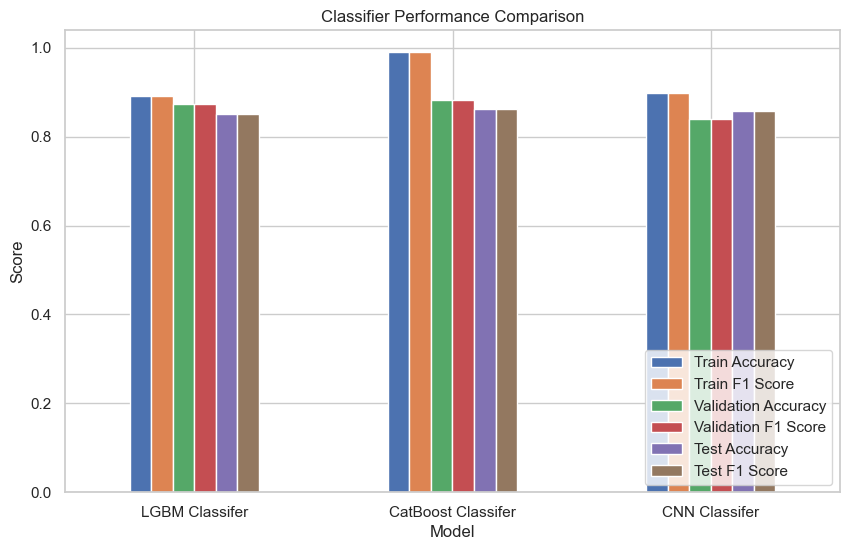

In [146]:
# Draw a bar chart for each indicator
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
metrics = ['Train Accuracy', 'Train F1 Score', 'Validation Accuracy', 'Validation F1 Score', 'Test Accuracy', 'Test F1 Score']
results_acc.plot(x='Model', y=metrics, kind='bar', ax=ax)

# Set title and tags
plt.title('Classifier Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')

# Show bar Chart
plt.show()


## 5. The Best Classifier

In [147]:
def train_best_model(x_train,y_train,x_val,y_val,x_test,y_test):
    #catboost with best parameters
    best_catboost = CatBoostClassifier(**best_catboost_params)
    best_catboost.fit(x_train, y_train)

    # predict
    y_train_pred = best_catboost.predict(x_train)
    y_val_pred = best_catboost.predict(x_val)
    y_test_pred = best_catboost.predict(x_test)

    # accuracy
    train_acc = accuracy_score(y_train,y_train_pred)
    val_acc = accuracy_score(y_val,y_val_pred)
    test_acc = accuracy_score(y_test,y_test_pred)

    # Calculate the precision, recall, and F1 score on the train set
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')

    # Calculate the precision, recall, and F1 score on the validation set
    val_precision = precision_score(y_val, y_val_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')

    # Calculate the precision, recall, and F1 score on the test set
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # print
    print(f"Train Accuracy: {train_acc:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

    return  best_catboost

In [148]:
best_classifer = train_best_model(X_train_koi,y_train_koi,X_val_koi,y_val_koi,X_test_koi,y_test_koi)

0:	learn: 0.5438234	total: 3.07ms	remaining: 879ms
1:	learn: 0.4489417	total: 6.12ms	remaining: 871ms
2:	learn: 0.3976303	total: 8.07ms	remaining: 764ms
3:	learn: 0.3719295	total: 10.3ms	remaining: 729ms
4:	learn: 0.3551116	total: 12.7ms	remaining: 714ms
5:	learn: 0.3422412	total: 14.7ms	remaining: 690ms
6:	learn: 0.3324048	total: 17.1ms	remaining: 685ms
7:	learn: 0.3264061	total: 19.8ms	remaining: 690ms
8:	learn: 0.3198964	total: 22ms	remaining: 679ms
9:	learn: 0.3136202	total: 24.1ms	remaining: 668ms
10:	learn: 0.3087346	total: 26.5ms	remaining: 665ms
11:	learn: 0.3051076	total: 29.3ms	remaining: 671ms
12:	learn: 0.3025775	total: 31.5ms	remaining: 663ms
13:	learn: 0.2993206	total: 33.9ms	remaining: 661ms
14:	learn: 0.2970320	total: 36ms	remaining: 652ms
15:	learn: 0.2942906	total: 38.7ms	remaining: 655ms
16:	learn: 0.2917837	total: 41.2ms	remaining: 654ms
17:	learn: 0.2872026	total: 43.7ms	remaining: 653ms
18:	learn: 0.2849819	total: 46.2ms	remaining: 651ms
19:	learn: 0.2818950	total

## 6. Output the file for web

In [157]:
# best model file
best_classifer.save_model("best_model.cbm")

In [153]:
# feature names
feature_names = list(X_train_koi.columns)
with open("features.json", "w", encoding="utf-8") as f:
    json.dump({"features": feature_names}, f, ensure_ascii=False, indent=2)

In [ ]:
# standardizer
std_params = {"features": feature_names,
              "mean":  np.asarray(scaler_koi.mean_).tolist(),
              "scale": np.asarray(scaler_koi.scale_).tolist()}
json.dump(std_params, open("standardizer.json","w"), indent=2)